# Box–Jenkins method

[Wiki Pages](https://en.wikipedia.org/wiki/Box–Jenkins_method)

[How to Create an ARIMA Model for Time Series Forecasting with Python](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)

[AR(I)MA时间序列建模过程——步骤和python代码](https://www.jianshu.com/p/cced6617b423)

[Python 3中使用ARIMA进行时间序列预测的指南](https://www.howtoing.com/a-guide-to-time-series-forecasting-with-arima-in-python-3)

[A comprehensive beginner’s guide to create a Time Series Forecast (with Codes in Python)](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/)

In [1]:
from __future__ import print_function, division, with_statement

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import statsmodels.api as sm

In [4]:
data = pd.read_csv("./foshan",sep='\t')

In [5]:
#data['Hosp_kind'] = data['Hosp_kind'].apply(lambda x: 4 if x==9 else x)
data['Date'] = data['Date'].apply(pd.to_datetime,format='%Y%m%d')

In [6]:
data.tail(10)

,Date,In_kind,Hosp_kind,People,Cost
7468,2018-05-29,2,3,410,3223561.87
7469,2018-05-30,1,1,35,207370.20
7470,2018-05-30,1,2,305,1476177.39
7471,2018-05-30,1,3,510,4077665.89
7472,2018-05-30,2,1,26,91558.97
7473,2018-05-30,2,2,318,1812640.45
7474,2018-05-30,2,3,462,3805353.44
7475,2018-05-31,1,2,2,33786.94
7476,2018-05-31,1,3,7,74144.99
7477,2018-05-31,2,3,7,63990.91


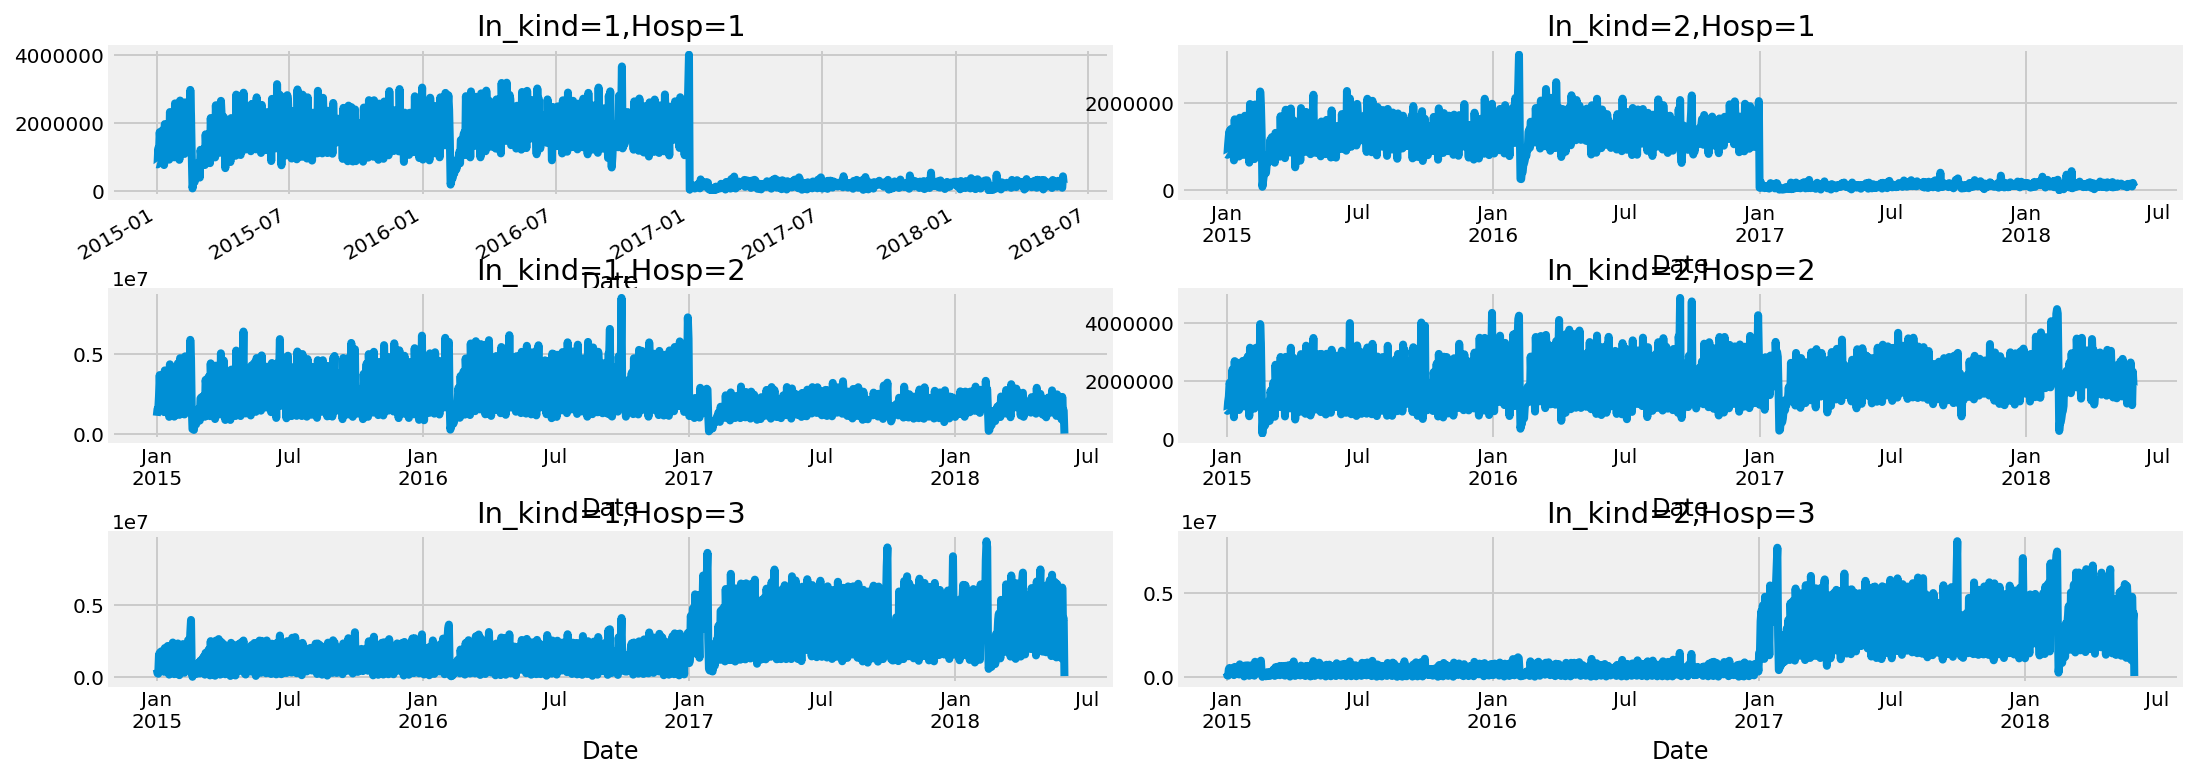

In [7]:
fig, ax = plt.subplots(nrows=3, ncols=2,figsize=plt.figaspect(0.2))
fig.tight_layout()
for i,row in enumerate(ax):
    for j,axs in enumerate(row):
        data[(data['In_kind']==j+1) & (data["Hosp_kind"]==i+1) ].groupby(['Date'])['Cost'].sum().plot(ax=axs,figsize=(15,6))
        axs.set(title='In_kind={},Hosp={}'.format(j+1,i+1))
        #axs.axes.get_xaxis().set_visible(False)

plt.show()

In [8]:
test = data[(data['In_kind']==1)].groupby(['Date'])['Cost'].sum()

In [9]:
test.drop(test.index[-1],inplace=True)

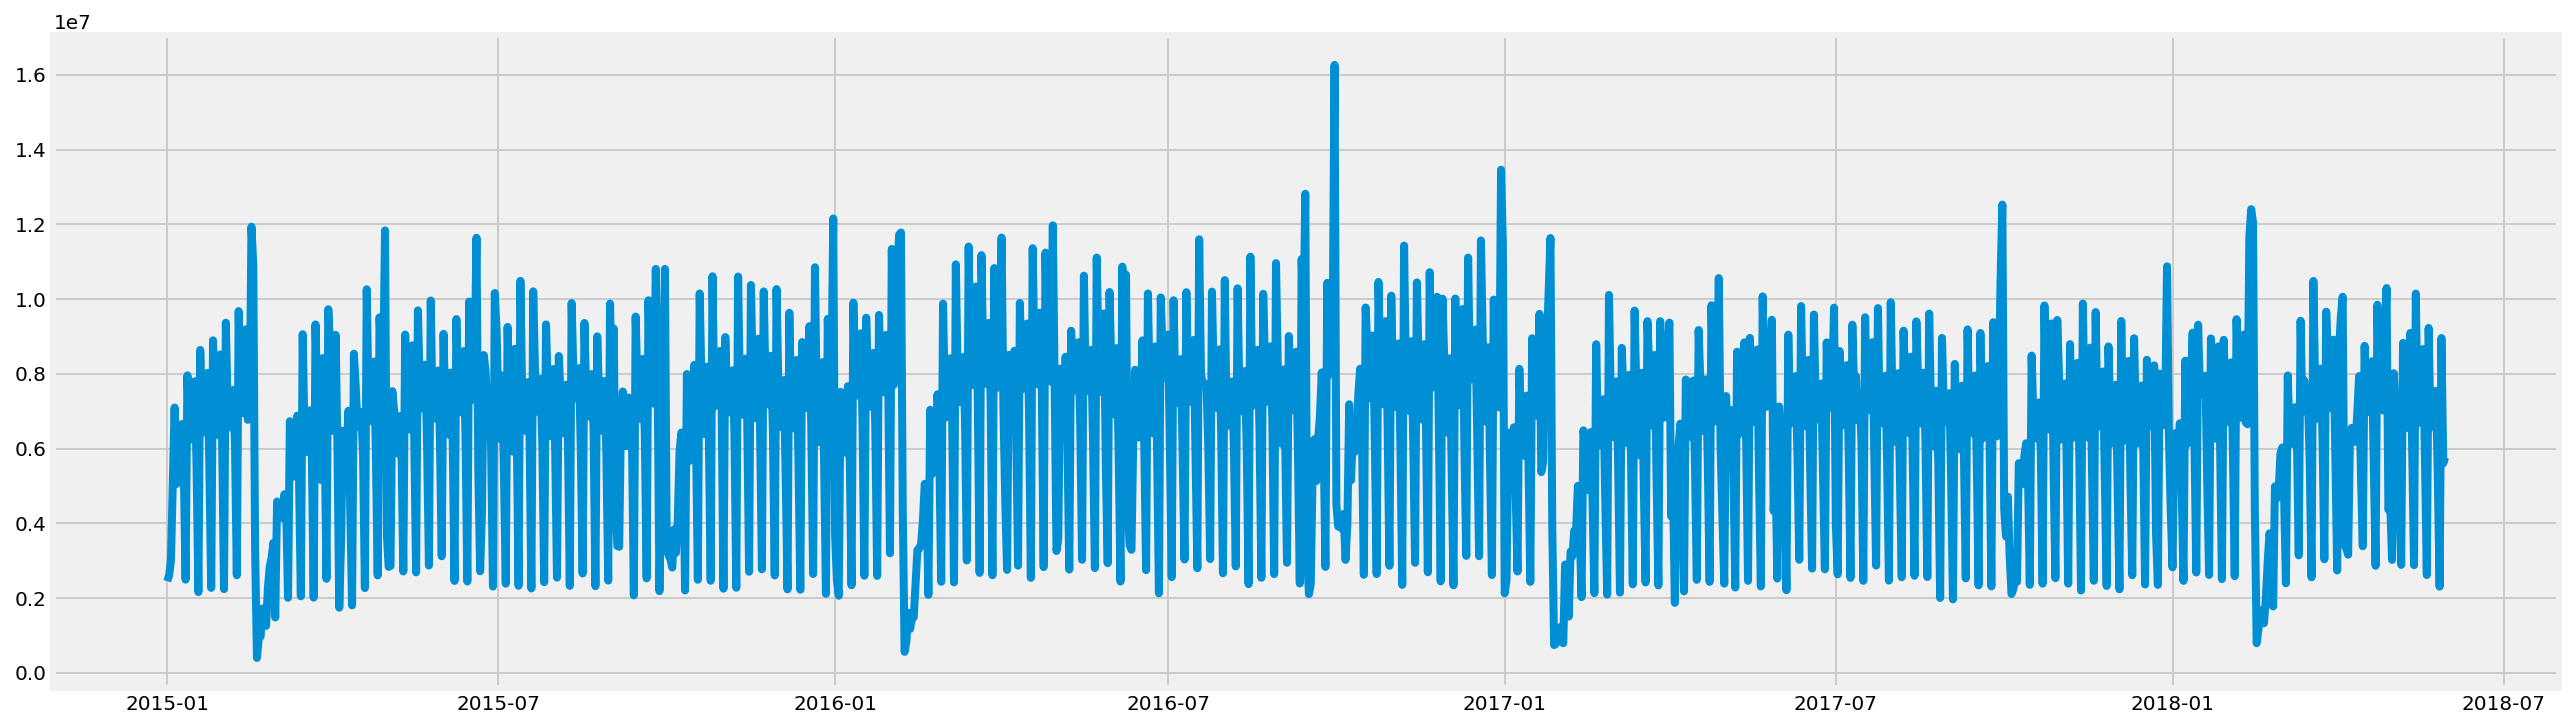

In [10]:
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(test)

In [12]:
import warnings
warnings.filterwarnings("ignore")
import statsmodels.tsa.stattools as st
order = st.arma_order_select_ic(test.values,max_ar=5,max_ma=5,ic=['aic', 'bic', 'hqic'])
order.bic_min_order

(4, 4)

In [13]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    print(dftest)
    return dftest[1]

In [14]:
def produce_diffed_timeseries(df, diffn):
    if diffn != 0:
        df['diff'] = df[df.columns[1]].apply(lambda x:float(x)).diff(diffn)
    else:
        df['diff'] = df[df.columns[1]].apply(lambda x:float(x))
    df.dropna(inplace=True) #差分之后的nan去掉
    return df


In [15]:

if test_stationarity(test.values) < 0.01:
    print('平稳，不需要差分')
else:
    diffn = best_diff(train, maxdiff = 8)
    train = produce_diffed_timeseries(train, diffn)
    print('差分阶数为'+str(diffn)+'，已完成差分')



(-6.728190778802209, 3.3478024374866453e-09, 21, 1224, {'1%': -3.4357038129673962, '5%': -2.8639042041471887, '10%': -2.5680287376916997}, 38423.56894842829)
平稳，不需要差分


In [16]:
from statsmodels.tsa.arima_model import ARIMA

In [17]:
model = ARIMA(test.values, order=(3, 0, 4))  

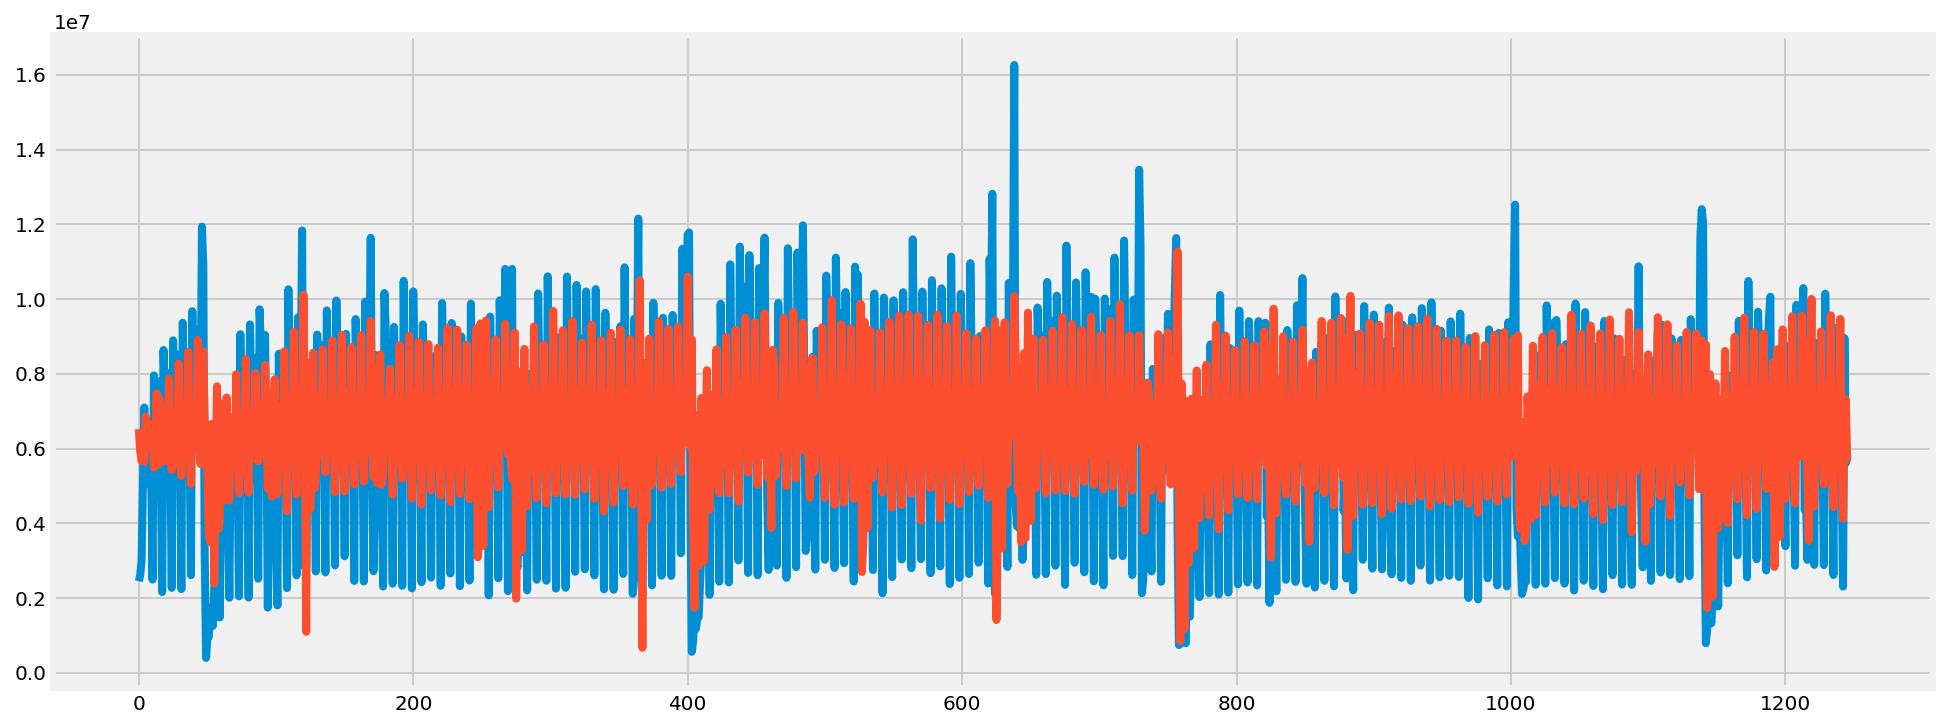

In [18]:
results_AR = model.fit(disp=-1)  

fig, ax = plt.subplots(figsize=(15,6))
ax.plot(test.values)
ax.plot(results_AR.fittedvalues)
#ax.plot(np.concatenate((results_AR.fittedvalues,results_AR.predict(150,177))), color='red')
#plt.plot(results_AR.predict(160,177), color='green')
#plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-test.values)**2))

In [19]:
results_AR.predict(160,177)

array([6497256.02579859, 6186424.81073633, 9034115.24606204,
       5883571.76773462, 5116879.85205114, 7153926.61377679,
       7047463.73518447, 6603508.09515823, 5899428.04474159,
       9414915.20118363, 7117854.81240925, 5239346.59318056,
       6115272.53053041, 6487498.0359435 , 5066062.18488896,
       7969954.27147506, 8518219.21893573, 5030389.02242926])

In [20]:
mod = sm.tsa.statespace.SARIMAX(test.values[0:140],
                                order=(2, 0, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)


In [21]:
result = mod.fit()

In [22]:
pred = result.predict(140,177)

In [23]:
pred = pd.Series(pred,index=range(139,177))

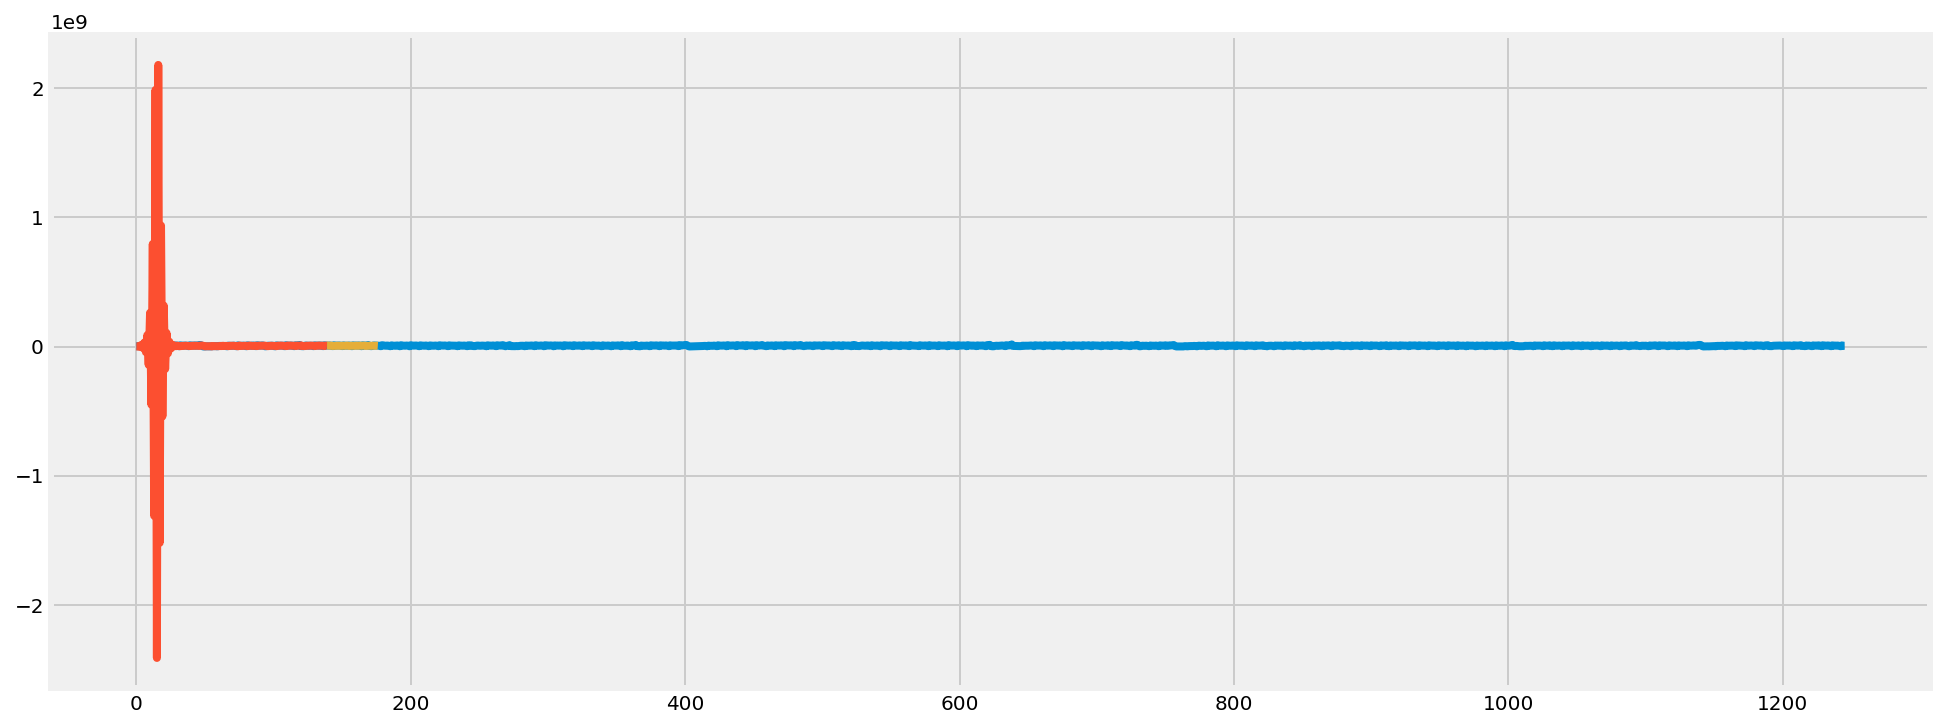

In [24]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(test.values)
ax.plot(result.fittedvalues)
ax.plot(pred)
#pred.predicted_mean.plot(ax=ax)
#ax.plot(np.concatenate((result.fittedvalues,result.predict(140,177))), color='red')

In [25]:
print(result.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0687      0.435     -0.158      0.875      -0.921       0.784
ar.L2          0.4027      0.433      0.931      0.352      -0.445       1.251
ma.L1          1.7610      0.031     56.176      0.000       1.700       1.822
ar.S.L12      -0.2745      0.701     -0.392      0.695      -1.649       1.100
ma.S.L12      -0.7275      0.374     -1.945      0.052      -1.461       0.006
sigma2      1.105e+13   1.88e-14   5.87e+26      0.000    1.11e+13    1.11e+13


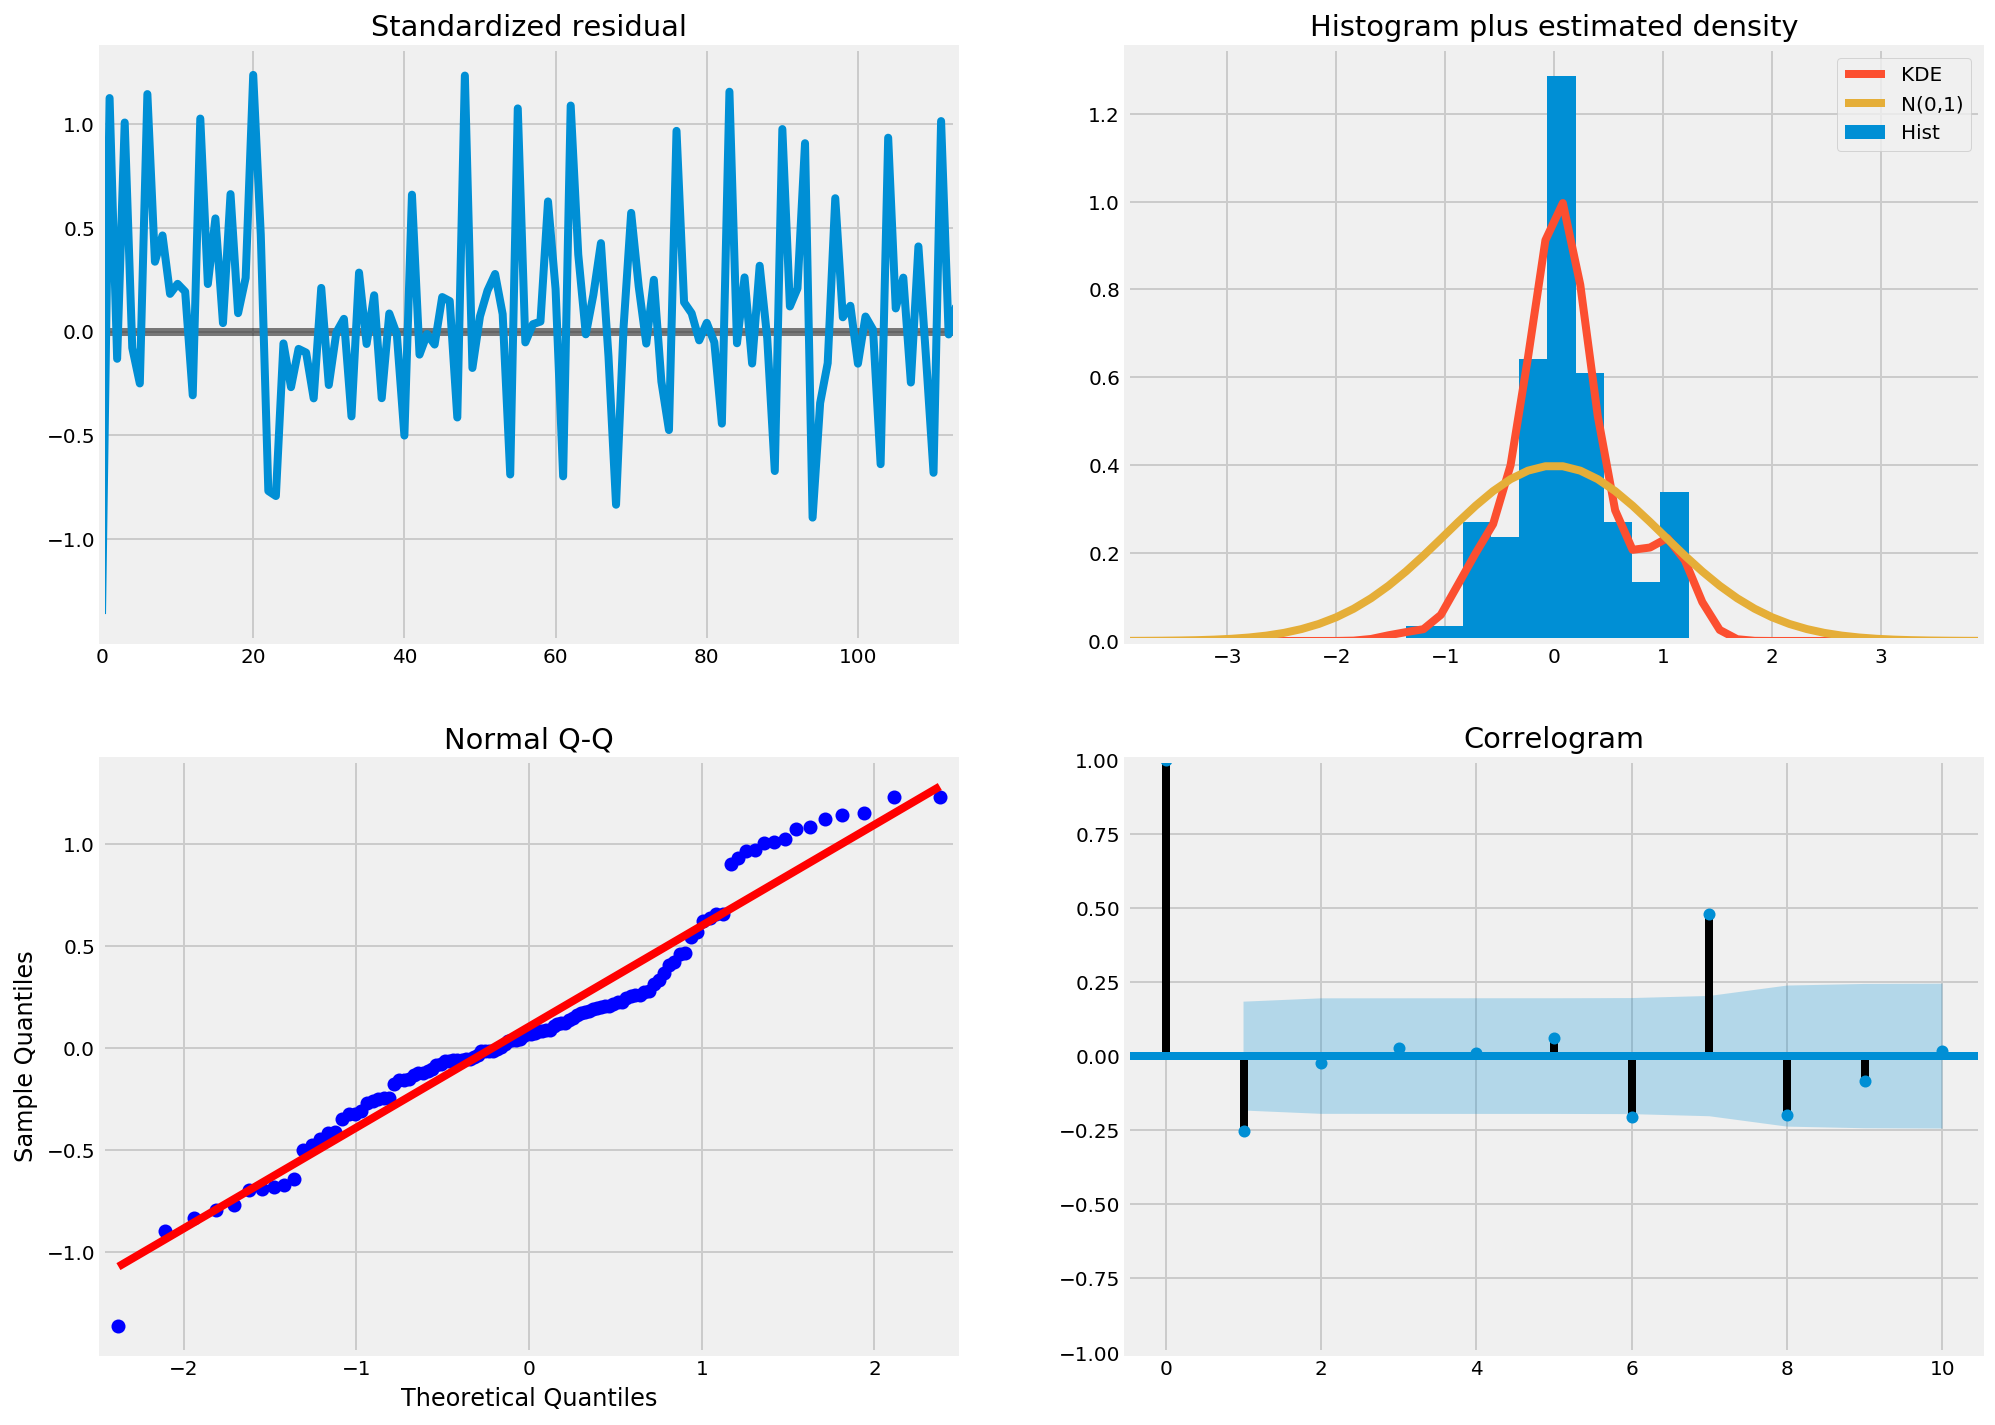

In [26]:
result.plot_diagnostics(figsize=(15, 12))
plt.show()

----

# Work on days 

In [27]:
data = pd.read_csv("./ZhanJiang_all",sep='\t')

In [28]:
data['Hosp_kind'] = data['Hosp_kind'].apply(lambda x: 4 if x==9 else x)

In [29]:
data['Date'] = data['Date'].apply(pd.to_datetime,format='%Y%m%d')

In [30]:
test = data[(data['In_kind']==1) & (data["Hosp_kind"]==3) ].groupby(['Date'])['Cost'].sum()

### test month pattern

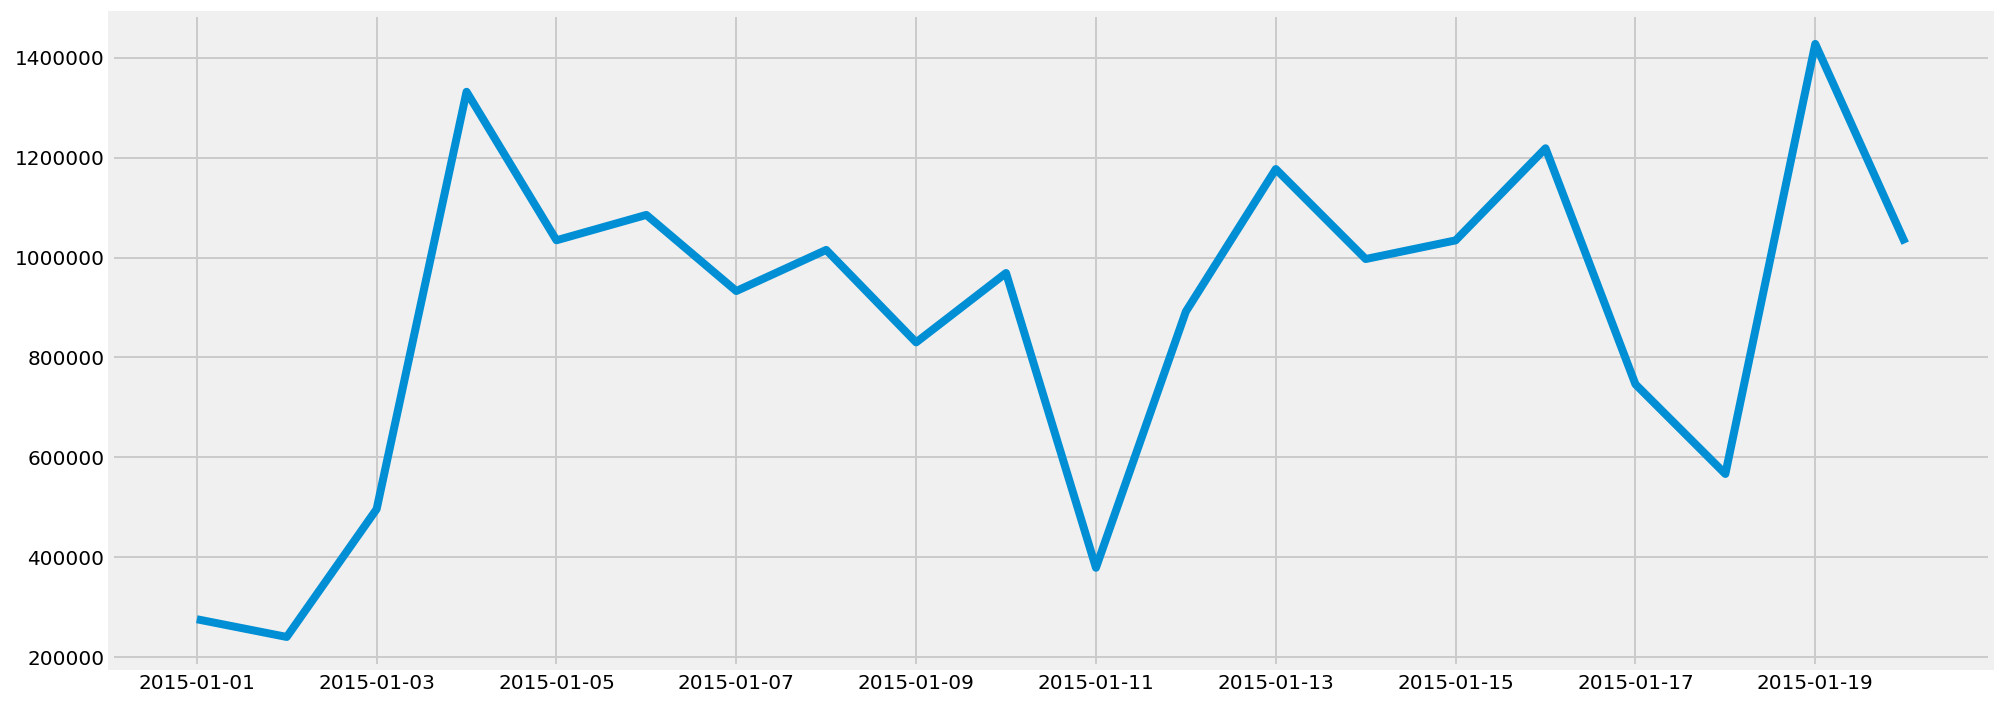

In [31]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(test[0:20])
#ax.plot(test[61:121])

---

## ARIMA

In [32]:
model = ARIMA(test.values, order=(5, 0, 5))  

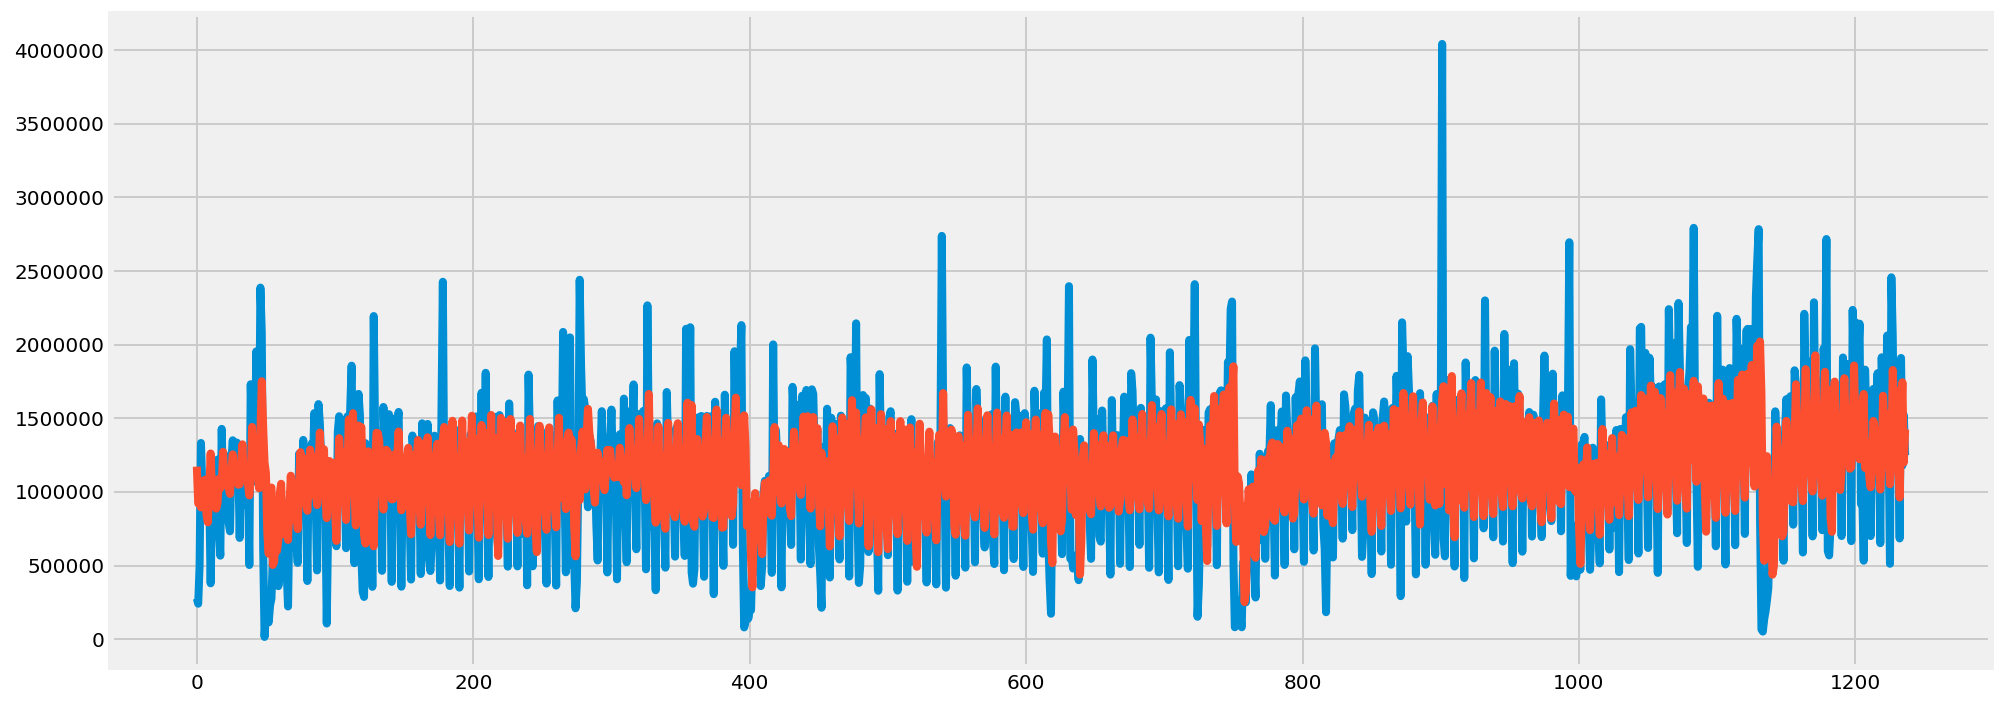

In [33]:
results_AR = model.fit(disp=-1)  

fig, ax = plt.subplots(figsize=(15,6))
ax.plot(test.values)
ax.plot(results_AR.fittedvalues)

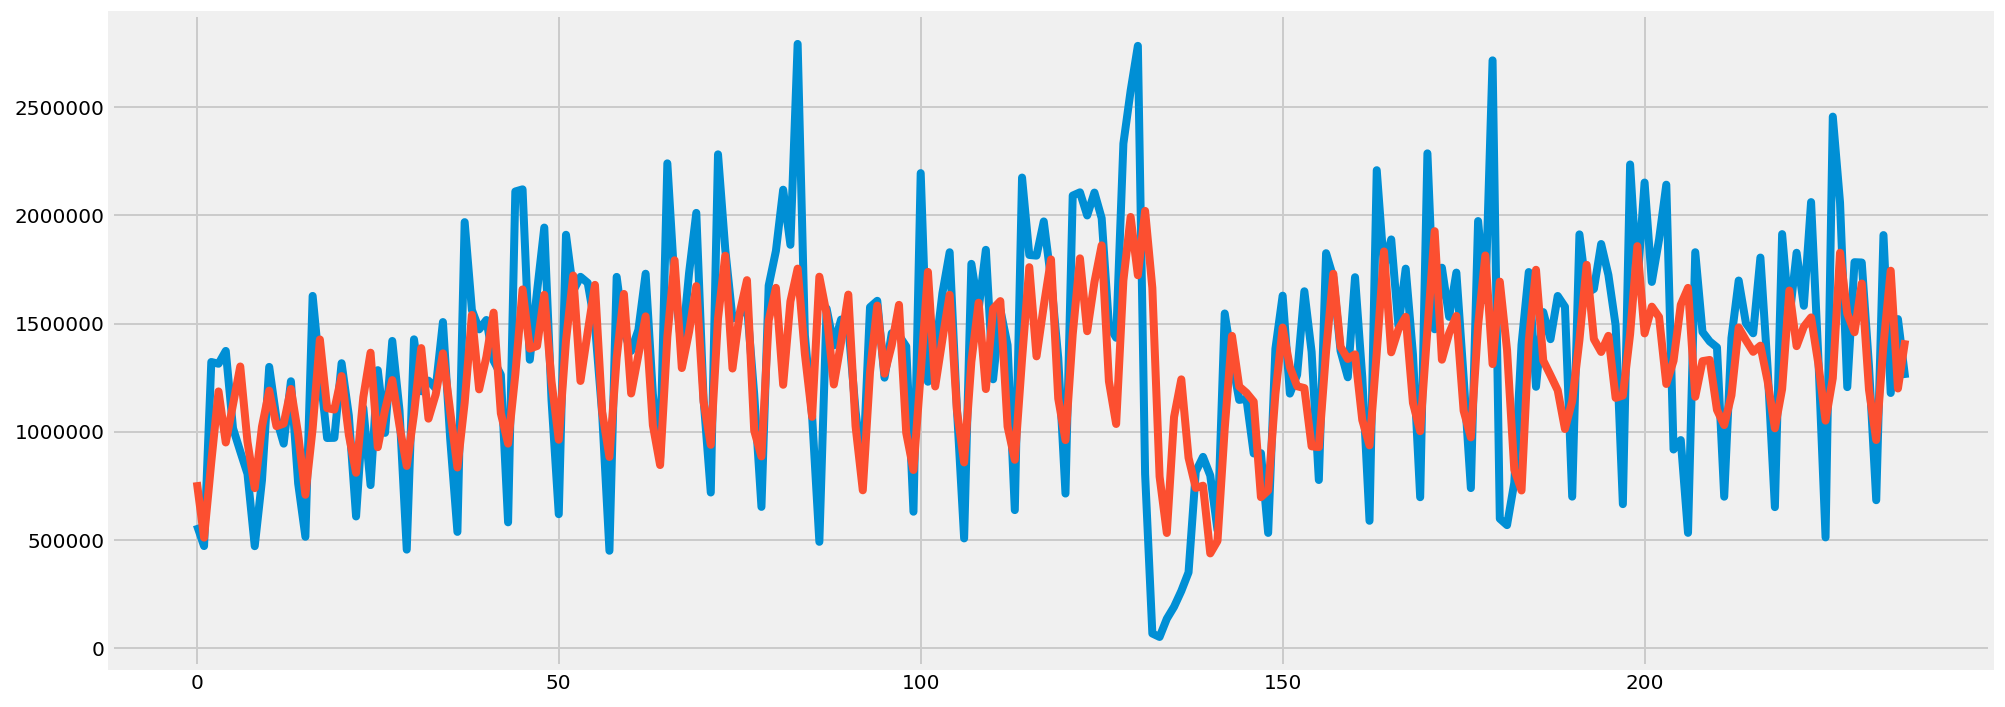

In [34]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(test.values[1000:])
ax.plot(results_AR.fittedvalues[1000:])

### test for ARIMA

In [35]:
test.shape

(1237,)

In [36]:
model = ARIMA(test.values[0:1100], order=(3, 0, 4))  
results_AR = model.fit(disp=-1)  

In [37]:
pred = results_AR.predict(1100,test.shape[0])

In [38]:
pred3 = pd.Series(pred,index=range(1099,test.shape[0]))
pred2 = pd.Series(pred,index = range(99,test.shape[0]-1100+99+1))

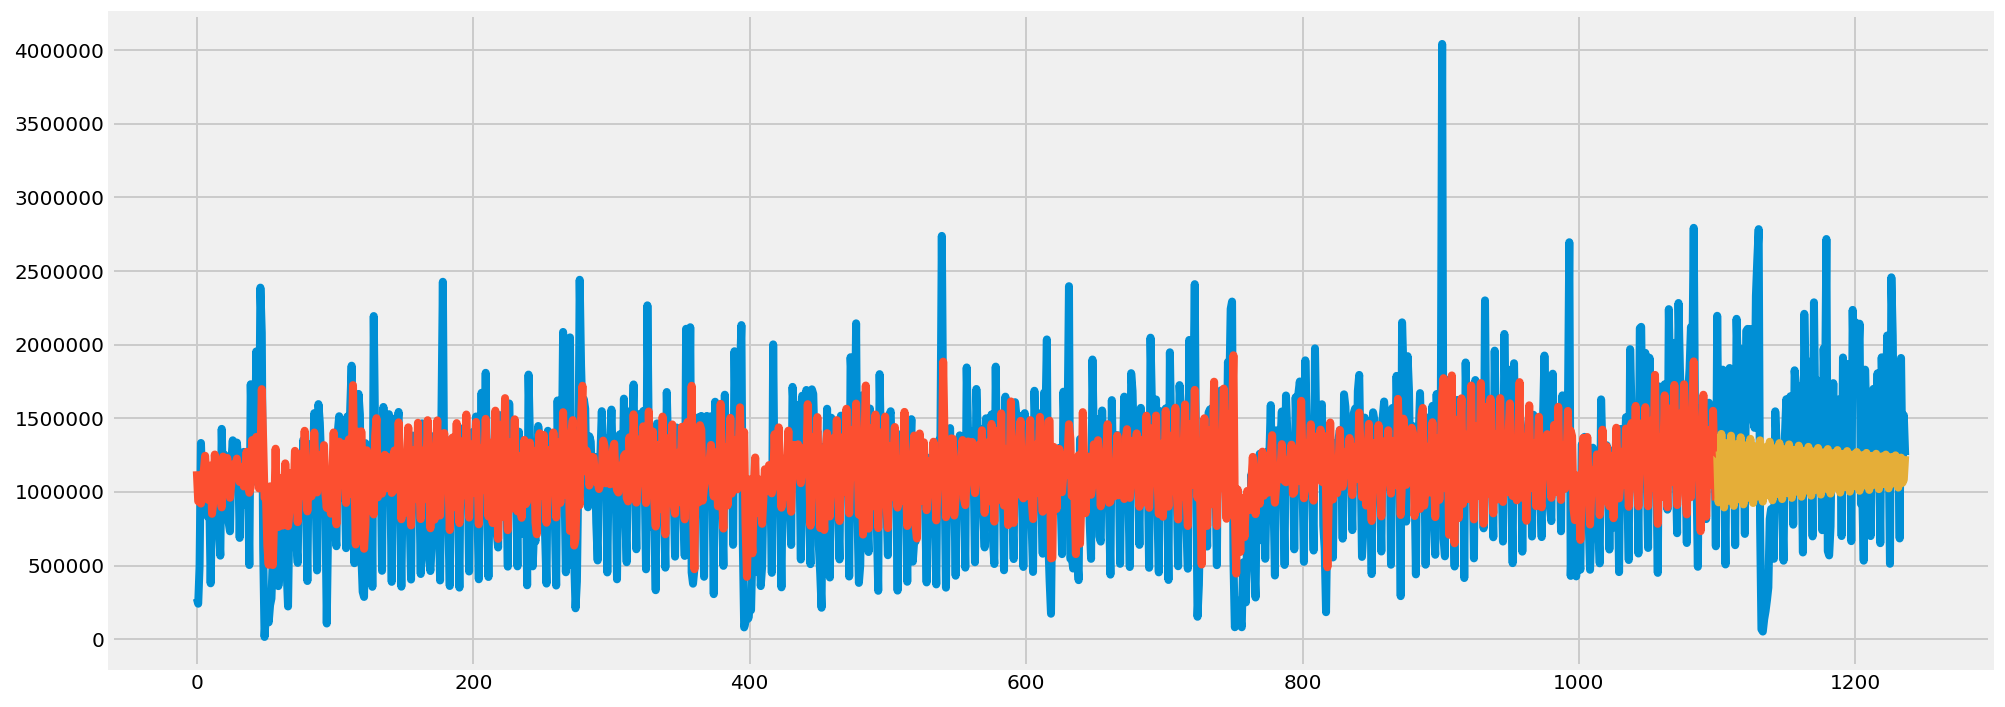

In [39]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(test.values)
ax.plot(results_AR.fittedvalues)
ax.plot(pred3)

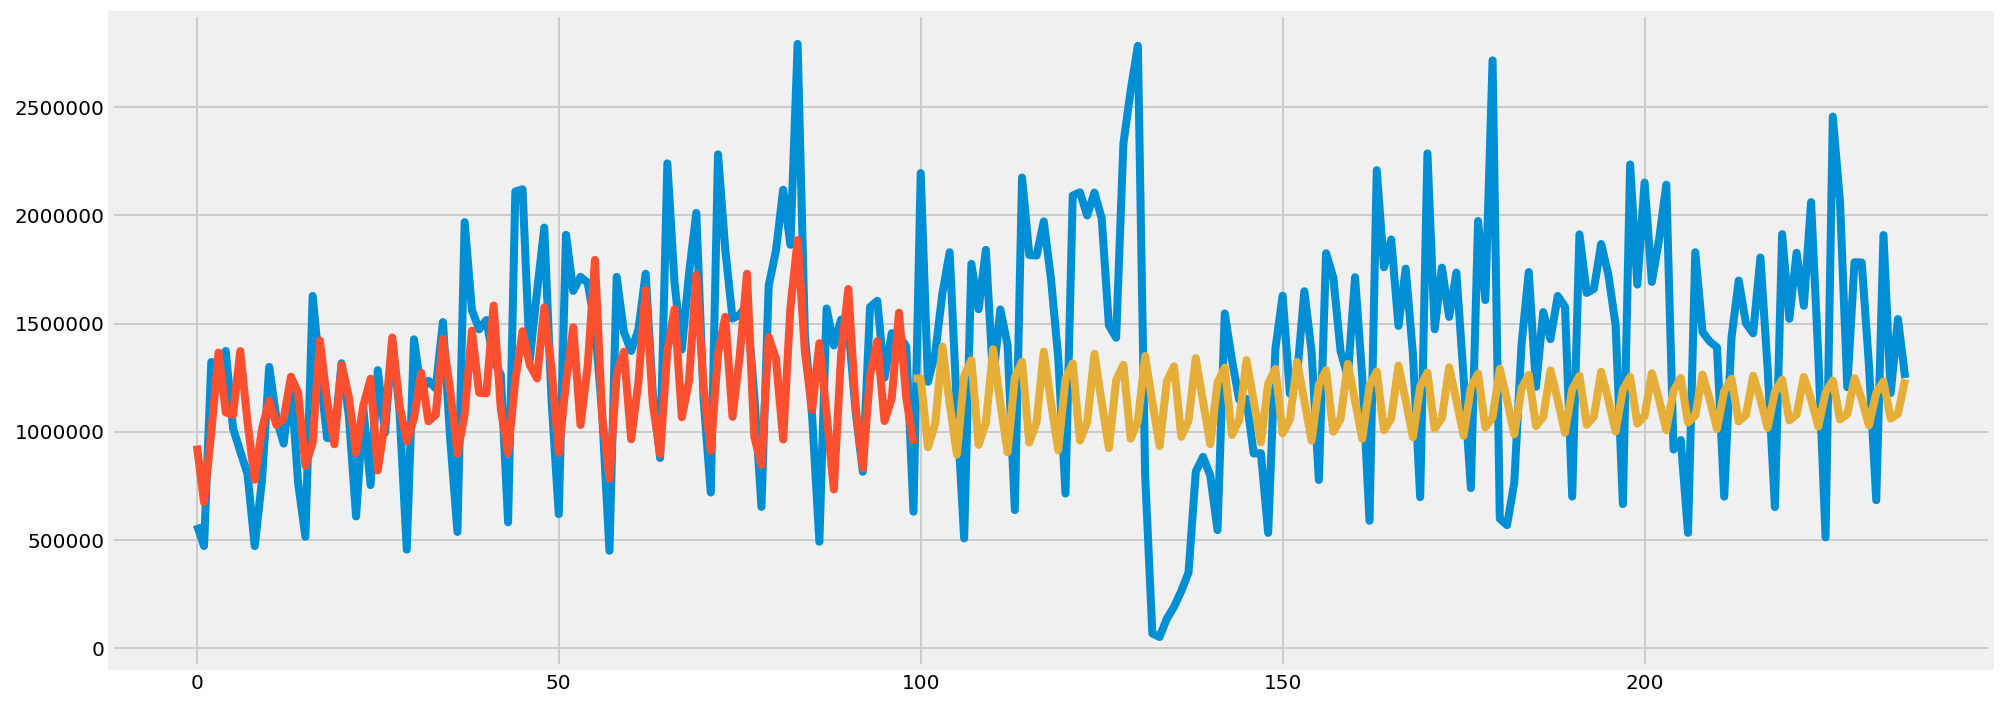

In [40]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(test.values[1000:])
ax.plot(results_AR.fittedvalues[1000:])
ax.plot(pred2)

## SARIMAX

In [41]:
mod = sm.tsa.statespace.SARIMAX(test.values[0:1100],
                                order=(3, 0, 4),
                                seasonal_order=(1, 1, 1, 14),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

In [42]:
result = mod.fit()

In [43]:
pred = result.predict(1100,test.shape[0])

In [44]:
pred3 = pd.Series(pred,index=range(1099,test.shape[0]))

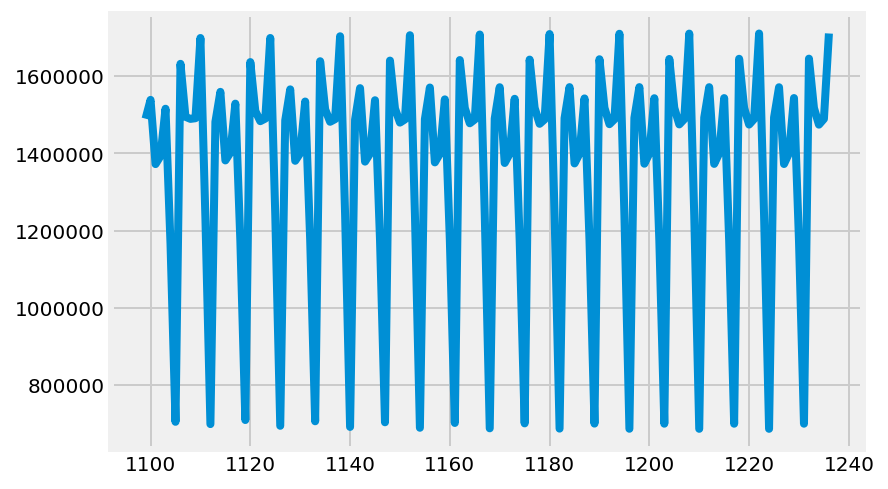

In [45]:
pred3.plot()

In [46]:
pred2 = pd.Series(pred,index = range(99,test.shape[0]-1100+99+1))

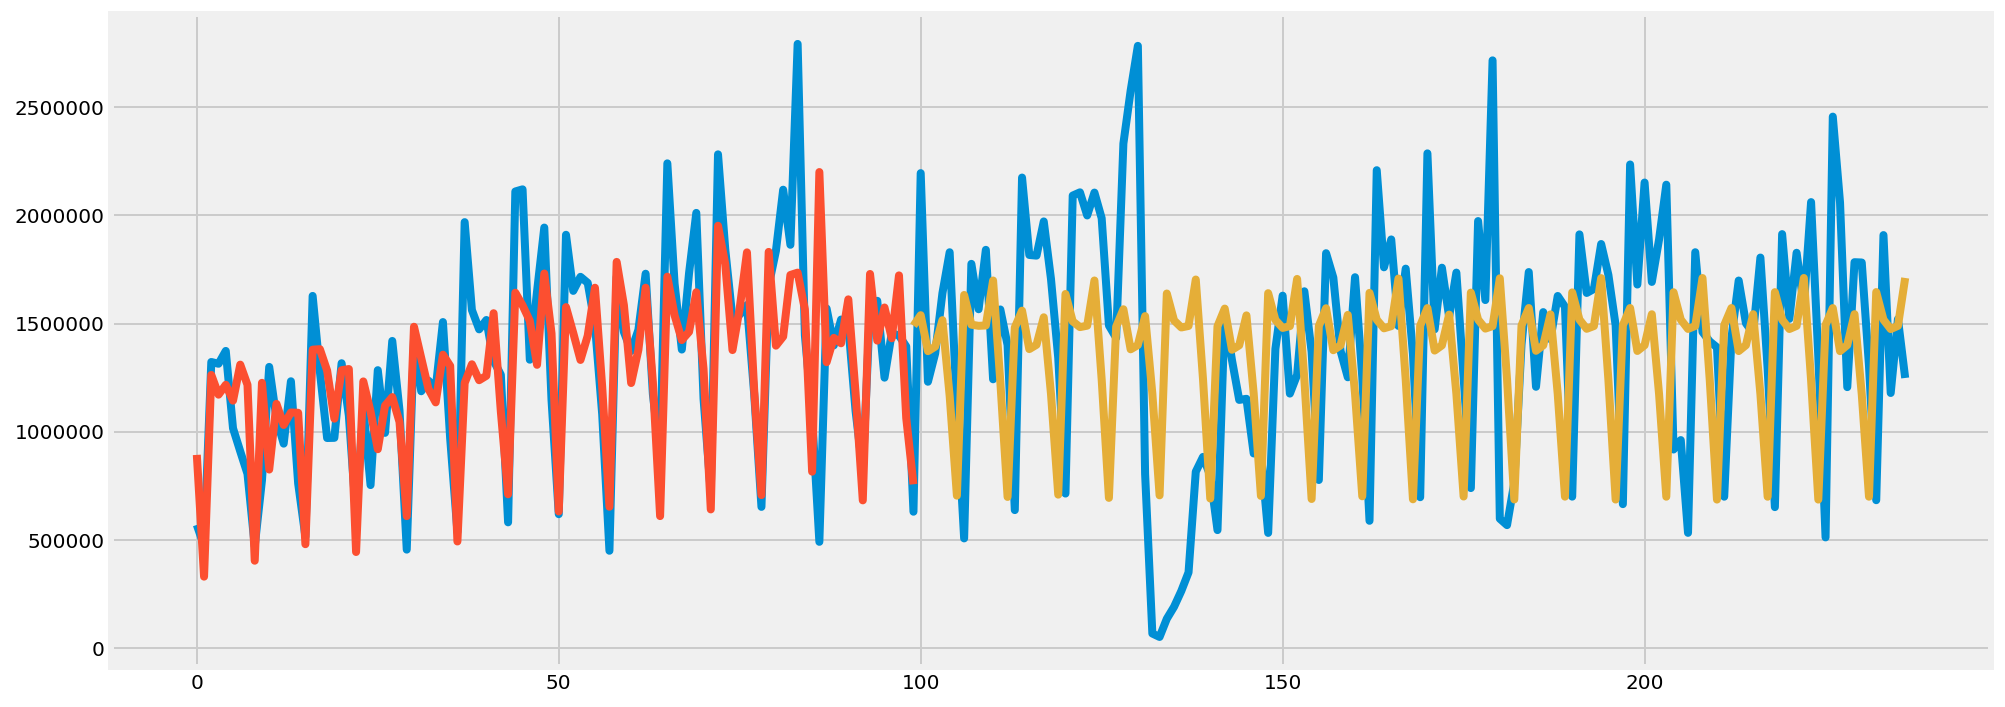

In [47]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(test.values[1000:])
ax.plot(result.fittedvalues[1000:])
ax.plot(pred2)

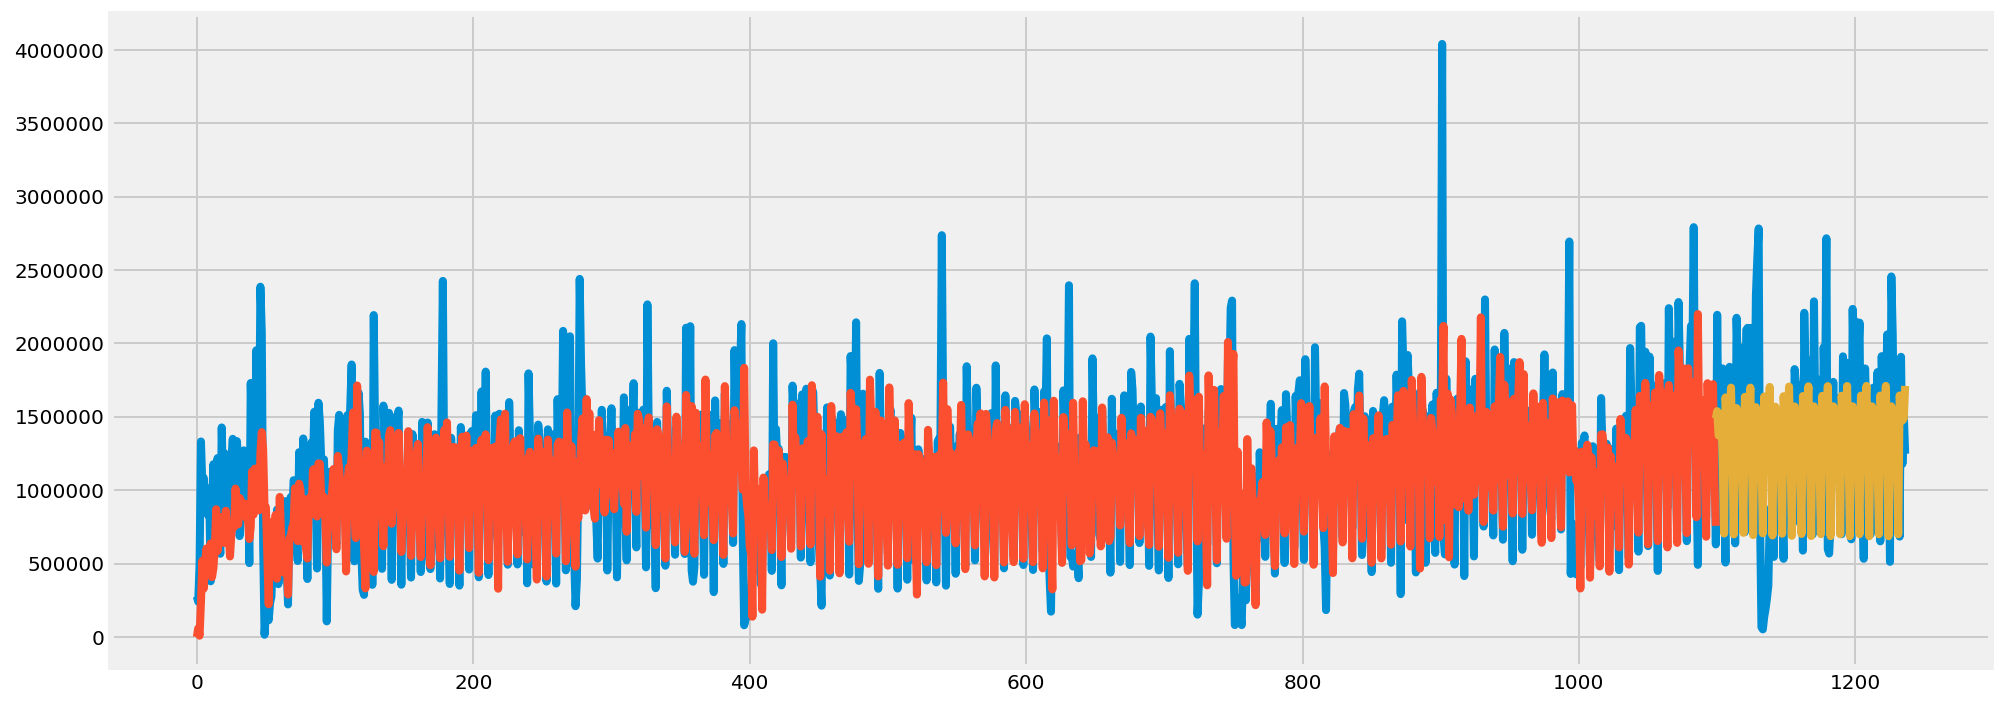

In [48]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(test.values)
ax.plot(result.fittedvalues)
ax.plot(pred3)

In [11]:
import itertools

In [12]:
d = range(0,2)
p = q = range(0, 10)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 14) for x in list(itertools.product(p, d, q))]

In [13]:
#warnings.filterwarnings("ignore") # specify to ignore warning messages
min_value = 50000

for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(test.values,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)

        results = mod.fit()
        if min_value > results.aic :
            min_value = results.aic
            pm,pm_s = param, param_seasonal
        
        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
#         except:
#             continue

ARIMA(0, 0, 0)x(0, 0, 0, 14)12 - AIC:42769.01039809408
ARIMA(0, 0, 0)x(0, 0, 1, 14)12 - AIC:41611.724938727995
ARIMA(0, 0, 0)x(0, 0, 2, 14)12 - AIC:40943.276996994085
ARIMA(0, 0, 0)x(0, 0, 3, 14)12 - AIC:40409.515911112205
ARIMA(0, 0, 0)x(0, 0, 4, 14)12 - AIC:39895.4318075447


KeyboardInterrupt: 

In [ ]:
pm,pm_s